## What salary could get a candidate after transition?

To support data analysts transitioning to data science roles, we build a xgboost model to estimate salary differences based on key skills we defined for transition. on this section we:

- Remove salary outliers and filter for Data Scientist job postings
- Engineer binary skill features
- Train an XGBoost regression model
- Predict the monthly salary in EUR

### Import Libraries

In [ ]:
from pathlib import Path
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

### Load Cleaned Dataset

In [11]:
df = pd.read_pickle(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final_2.pkl')

### Predicting Data Scientist Salaries Based on Analyst Transition Skills

To support data analysts transitioning to data science roles, we build a regression model to estimate salary on base of skillset we defined as the most appropriate for transition.

- **Target Role:** Data Scientist  
- **Base Skills:** `Python`, `SQL`, `Tableau`/`Looker`/`Power BI`
- **Key Transition Skills:** `R`/`SAS`, `AWS`/`Azure`, `Spark`/`Tensorflow`, `Pytorch`

In [23]:
df_ml = df[df['job_title_short'] == 'Data Scientist'].copy()

print(f"Valid Data Scientist rows: {len(df_ml)}")

Valid Data Scientist rows: 9507


### Skill Feature Engineering

We create binary features to represent whether a posting mentions:
- Base skills (Excel, Python, SQL, BI tools)
- Transition skills (R/SAS, AWS/Azure, Spark/TensorFlow/PyTorch)

We also add:
- Total skill count
- A composite binary meets_criteria flag for candidates having all required skills.

In [13]:
# Lowercase skill lists
df_ml['job_skills'] = df_ml['job_skills'].apply(lambda x: [s.lower() for s in x] if isinstance(x, list) else [])

# Define skill groups
viz_tools = ['tableau', 'power bi', 'looker']
r_sas = ['r', 'sas']
spark_tf_pt = ['spark', 'tensorflow', 'pytorch']
aws_azure = ['aws', 'azure']

# Individual known skills
df_ml['has_python'] = df_ml['job_skills'].apply(lambda skills: 'python' in skills).astype(int)
df_ml['has_sql'] = df_ml['job_skills'].apply(lambda skills: 'sql' in skills).astype(int)
df_ml['has_excel'] = df_ml['job_skills'].apply(lambda skills: 'excel' in skills).astype(int)

# Group features
df_ml['has_viz_tool'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in viz_tools)).astype(int)
df_ml['has_r_sas'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in r_sas)).astype(int)
df_ml['has_spark_tf_pt'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in spark_tf_pt)).astype(int)
df_ml['has_aws_azure'] = df_ml['job_skills'].apply(lambda skills: any(v in skills for v in aws_azure)).astype(int)

# List of skill features
skill_cols = ['has_excel','has_python','has_sql','has_viz_tool',
              'has_r_sas','has_spark_tf_pt','has_aws_azure','total_skills','meets_criteria']

# Total skills count in posting
df_ml['total_skills'] = df_ml['job_skills'].apply(len)

# Composite feature: candidate meets all conditions
df_ml['meets_criteria'] = (
    df_ml['has_excel'] &
    df_ml['has_python'] &
    df_ml['has_sql'] &
    df_ml['has_viz_tool'] &
    df_ml['has_r_sas'] &
    df_ml['has_spark_tf_pt'] &
    df_ml['has_aws_azure']
).astype(int)

df_ml[skill_cols].sum()

has_excel           1054
has_python          7763
has_sql             5727
has_viz_tool        2508
has_r_sas           4597
has_spark_tf_pt     2783
has_aws_azure       2313
total_skills       54603
meets_criteria        29
dtype: int64

### Encode categorical variables

In [14]:
# Multi-hot schedule type
schedule_types = ["Full-time", "Part-time", "Contractor", "Temp work", "Internship"]

for s in schedule_types:
    col = "schedule_" + s.lower().replace(" ", "_").replace("-", "_")
    # Assign 1 if schedule string contains this type, else 0
    df_ml[col] = df_ml['job_schedule_type'].fillna("").apply(lambda x: int(s in x))

# Additional categorical/binary features
df_ml['is_us'] = (df_ml['job_country'] == "United States").astype(int)

# Collect categorical/binary columns (no schedule_missing here)
categorical_cols = ['is_eu', 'is_us', 'job_work_from_home', 'job_health_insurance']
categorical_cols += [c for c in df_ml.columns if c.startswith("schedule_")]

print("Categorical/binary features counts:\n")
print(df_ml[categorical_cols].sum())

Categorical/binary features counts:

is_eu                    328
is_us                   7480
job_work_from_home      1809
job_health_insurance    4925
schedule_full_time      9247
schedule_part_time       555
schedule_contractor      265
schedule_temp_work        95
schedule_internship       65
dtype: int64


### Merge all features into modeling dataset

In [15]:
# All model features
model_features = skill_cols + categorical_cols

# Target
y = df_ml['salary_month_avg_eur']
X = df_ml[model_features]

# Summary of df_model
print(f"\ndf_model created with {df_ml.shape[0]} rows and {df_ml.shape[1]} features.")
print("Target variable: salary_month_avg_eur")


df_model created with 9507 rows and 35 features.
Target variable: salary_month_avg_eur


### Train XGBoost model

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train
model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Optional: evaluate
print("Training R^2:", model.score(X_train, y_train))
print("Test R^2:", model.score(X_test, y_test))

Training R^2: 0.3545002983394784
Test R^2: 0.14617752139714746


### Candidate prediction

In [17]:
# Candidate feature vector
candidate_features = pd.DataFrame([{
    'has_excel': 0,
    'has_python': 1,
    'has_sql': 1,
    'has_viz_tool': 1,
    'has_r_sas': 1,
    'has_spark_tf_pt': 1,
    'has_aws_azure': 1,
    'total_skills': 6,
    'meets_criteria': 0,
    
    'is_eu': 1,
    'is_us': 0,
    'job_work_from_home': 0,
    'job_health_insurance': 0,
    
    'schedule_full_time': 1,
    'schedule_part_time': 0,
    'schedule_contractor': 0,
    'schedule_temp_work': 1,
    'schedule_internship': 0
    
}])

# Predict salary
predicted_salary = model.predict(candidate_features)[0]
print(f"Predicted salary for candidate: {predicted_salary:.2f} EUR/month")

Predicted salary for candidate: 12165.76 EUR/month


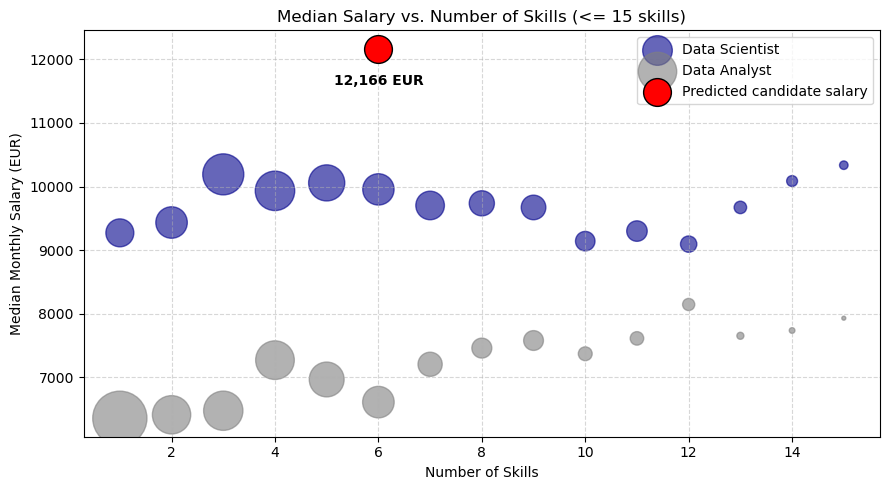

In [19]:
# Ensure total_skills exists for all postings
df['job_skills'] = df['job_skills'].apply(lambda x: [s.lower() for s in x] if isinstance(x, list) else [])
df['total_skills'] = df['job_skills'].apply(len)

# Filter <= 15 skills
df_ds_filtered = df[(df['job_title_short'] == 'Data Scientist') & (df['total_skills'] <= 15)]
df_da_filtered = df[(df['job_title_short'] == 'Data Analyst') & (df['total_skills'] <= 15)]

# Compute median salaries and counts per skill count
median_ds = df_ds_filtered.groupby('total_skills').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    count=('salary_month_avg_eur', 'size')
).reset_index()
median_da = df_da_filtered.groupby('total_skills').agg(
    median_salary=('salary_month_avg_eur', 'median'),
    count=('salary_month_avg_eur', 'size')
).reset_index()

# Plotting
plt.figure(figsize=(9,5))

# Data Scientist points
plt.scatter(
    median_ds['total_skills'],
    median_ds['median_salary'],
    s=median_ds['count']*0.6,  
    c='darkblue',
    alpha=0.6,
    label='Data Scientist'
)

# Data Analyst points
plt.scatter(
    median_da['total_skills'],
    median_da['median_salary'],
    s=median_da['count']*0.6,
    c='gray',
    alpha=0.6,
    label='Data Analyst'
)

# Predicted candidate salary
plt.scatter(
    candidate_features['total_skills'].iloc[0],
    predicted_salary,
    s=400,  
    c='red',
    edgecolor='black',
    label='Predicted candidate salary',
    zorder=5
)
plt.text(
    candidate_features['total_skills'].iloc[0],
    predicted_salary - predicted_salary * 0.05,
    f"{predicted_salary:,.0f} EUR",
    ha='center',
    va='bottom',
    fontsize=10,
    fontweight='bold'
)

# Axis labels and title
plt.xlabel('Number of Skills')
plt.ylabel('Median Monthly Salary (EUR)')
plt.title('Median Salary vs. Number of Skills (<= 15 skills)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()